In [2]:
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [7]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
# Downloading a sample of MNIST containing just 3 and 7s supplied by fastai
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

## Pixel Similarity Model

A method for a computer to distinguish between 3s and 7s may be to find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7.

To clasify an image as one digit or the other, we can see which of these two ideal digits the image is most similar to. This solution is better than nothing, so it will make a good baseline.


### Step 1: Get the average pixel values for each of our two groups

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image.

In [5]:
# Using List Comprehension to create a plain list of the single image tensors
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

# Checking that the number of returned items is reasonable
len(three_tensors), len(seven_tensors)

(6131, 6265)

<AxesSubplot:>

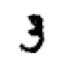

In [8]:
# Checking that one of the images looks OK
# Since we now have tensors, we will need to use fastai's *show_image* method to display it
show_image(three_tensors[0])

For every pixel position, we want to compute the average over all the images of that intensity of that pixel.

To do this, we first combine all the images in the list into a single three-dimensional tensor (rank-3 tensor).
We can use PyTorch's *stack* function to do this.

In [9]:
# Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types.
# Since we'll be needing this later, we'll also cast our stacked tensor to float.
# Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will divide by 255 here.

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

In [10]:
# Checking the shape of a stacked tensor
stacked_threes.shape

torch.Size([6131, 28, 28])

The most important attribute of a tensor is its shape. It tells you the length of each axis. In this case, we can see that we have 6131 images, each of size 28x28 pixels.

There is nothing specifically about this tensor that says that the first axis is the number of images, the second is height, and the third is width.

In [11]:
# The length of a tensor's shape is its rank
len(stacked_threes.shape)

3

Using the stacked tensors, we can compute what the ideal 3 and 7 looks like.

We do this by calculating the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.
The result will be one value for every pixel position, or a single image.

<AxesSubplot:>

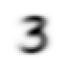

In [12]:
# Ideal 3
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

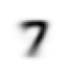

In [13]:
# Ideal 7
mean7 = stacked_sevens.mean(0)
show_image(mean7)

### Step 2: Measuring distance from our "ideal digits"

We can't just add up the differences between the pixels of an image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.

To avoid this, there are two main ways we can measure distance.
- Mean Absolute Difference or L1 norm: Take the mean of the absolute value of difference
- Root Mean Squared Error (RMSE) or L2 norm: Take the mean of the square of differences and then take the square root

<AxesSubplot:>

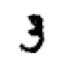

In [14]:
# Picking an arbitrary 3 and measuring its distance from our "ideal digits"
a_3 = stacked_threes[0]
show_image(a_3)

In [15]:
# Distance from Ideal 3
# Mean Absolute Difference or L1 norm
dist_3_abs = (a_3 - mean3).abs().mean()

# Mean Squared Difference or L2 norm
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(0.1074), tensor(0.1912))

In [16]:
# Distance from Ideal 7
# Mean Absolute Difference or L1 norm
dist_7_abs = (a_3 - mean7).abs().mean()

# Mean Squared Difference or L2 norm
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

dist_7_abs, dist_7_sqr

(tensor(0.1441), tensor(0.2780))

In both cases, the distance between our arbitrary 3 and the "ideal" 3 is less than the distance to the "ideal" 7.

So our simple model will give the right prediction in both cases.

In [17]:
# PyTorch already provides the L1 and L2 norms as loss functions, so we can use them directly instead of writing our own.
# PyTorch recommends torch.nn.functional as F, which fastai does by default.

F.l1_loss(a_3.float(),mean3), F.mse_loss(a_3.float(),mean3).sqrt()

# Note that mse stands for mean squared error and does not take the square root by default.
# Intuitively, the difference between L1 norm and the MSE is that MSE will penalize bigger mistakes more heavily.

(tensor(0.1074), tensor(0.1912))

### Step 3: Computing Metrics using Broadcasting

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.

For instance, we could use either the mean absolute error or mean squared error and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people.
In practice, we normally use accuracy as the metric for classification models.


We want to calculate our metric over a validation set, so we don't inadvertently overfit.

This is not really a risk with the pixel similarity model we're using here, since it has no trained components, but we'll use a validation set anyway to follow normal practices.

In [18]:
# Creating our tensors for 3s and 7s from our validation set, which we will use to calculate a metric measuring the quality of our model
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()]).float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()]).float()/255

# Checking the shape of our tensors
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Ultimately, we want to write a function ```is_3```, that will decide whether an arbitrary image is a 3 or a 7.
It will do this by deciding which of our two "ideal" digits this image is closer to. For that, we need to define a notion of distance.

We can write a simple function that calculates the mean absolute error.

In [19]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

# The tuple (-1,-2) represents the last two dimensions of the tensor. So in this case, it tells PyTorch that we want to take the mean ranging over the values in the horizontal and vertical dimensions of an image.
# After taking the mean, we are left with just the first tensor axis which indexes over our images.

In order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. 

We can do this by pass in ```valid_3_tens```, the tensor that represents the 3s validation set, into the distance function we defined.

In [20]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector of length 1010. 

When PyTorch tries to perform a simple subtraction operation between two tensors of different ranks, it will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. After broadcasting so that the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank, meaning it performs the operation of each corresponding element of the two tensors and returns the tensor result.

Therefore, in the above case, PyTorch treats ```mean3```, a rank-2 tensor (28, 28) representing a single image as if it were 1,010 copies of the same image and subtracts each of those copies from each 3 in our validation set.

In [21]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

We can use ```mnist_distance``` to figure out whether an image is a 3 or not buy using the following logic.
If the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it is a 3.

In [23]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

We can now use broadcasting to test the function on the full validation set of 3s.

In [24]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

We can now calculate the accuracy of each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s.

In [25]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = 1 - is_3(valid_7_tens).float().mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

But we can potentially do better by trying a system that does some real learning. That is, a system that can automatically modify itself to improve its performance.